In [1]:
import datetime as dt

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats


In [2]:
retail_df = pd.read_csv('../onlineRetail/OnlineRetail.csv', encoding="ISO-8859-1", sep = ',', header = 0)
print(f'Shape : {retail_df.shape}')
print(retail_df.info())

Shape : (541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


# 1. Clean & improve data

In [3]:
# drop all rows with null values
print(retail_df.isnull().sum()) 
retail_df = retail_df.dropna()
retail_df.shape

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


(406829, 8)

In [4]:
retail_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


### Descriptive values
>It can be seen that there is a 'UnitPrice' and 'Quantity', but there isn't a total amount column. We need a new *df* that contains the amount of money that every customer (*'CustomerID'*) spent. Those things will be useful in the future since we are using **RFM Clustering**.

> Another thing i will do is set InvoiceDate as a date_time data type         

In [5]:
# Amount column (quantity * unitPrice)
retail_df['amount'] = retail_df['Quantity']*retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [6]:
# Transfor to InvoiceDate to date_time data type
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'], format='%d-%m-%Y %H:%M')
retail_df 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


# 2. Important data features for modelling
In this step I will elaborate new dataframes that could be useful for modelling.
> Since the ***bussines goal*** is to use RFM clustering, we have to use recency, frequency, monetary values to clustering process:
> 1. Recency: Recency of purchase
> 2. Monetary: Monetary value of purchase
> 3. Frequency: Frequency of purchase. <br>
> *[RFM information](https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp)*

##### Amount of money every customer spent (Monetary)
> Monetary value stems from the lucrativeness of expenditures the customer makes with the business during their transactions. A natural inclination is to put more emphasis on encouraging customers who spend the most money to continue to do so. That will be useful because of two things: <br>
> 1. Can produce a better return on investment in marketing and customer service.
> 2. Companies runs the risk of alienating customers who have been consistent but have not spent as much with each transaction. That is why we have to relate monetary and recency values.



In [7]:
customerTotal_df = retail_df.groupby('CustomerID')['amount'].sum()
customerTotal_df = customerTotal_df.reset_index()
customerTotal_df

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2094.88


##### Frecuency of customers
> The frequency of a customer’s transactions may be affected by factors such as the type of product, the price point for the purchase, and the need for replenishment or replacement. If the purchase cycle can be predicted, for example when a customer needs to buy new groceries, marketing efforts could be directed towards reminding them to visit the business when items such as eggs or milk have been depleted.

In [8]:
# We count the amount of transactions of every single customer (grouped by 'CustomerID')
customerFrequency_df = retail_df.groupby('CustomerID')['InvoiceNo'].count()
customerFrequency_df = customerFrequency_df.reset_index()
customerFrequency_df.columns = ['CustomerID', 'Frequency']
customerFrequency_df

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


#### Merge customerFrequency_df and customerTotal_df
````Python 
DataFrame.merge(right, how='inner', on=None, ...)
````
> * *right*: DataFrame or named Series. Object to merge with. <br>
> * *how*: {‘left’, ‘right’, ‘outer’, ‘inner’, ‘cross’}, default ‘inner’. Type of merge to be performed. Similar to SQL joins. <br>
> * *on*: label or list. Column or index level names to join on. These must be found in both DataFrames. If on is None and not merging on indexes then this defaults to the intersection of the columns in both DataFrames.<br>

[Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html#pandas.DataFrame.merge)

In [9]:
grouped_df = pd.merge(customerFrequency_df, customerTotal_df, on = 'CustomerID')
grouped_df

,CustomerID,Frequency,amount
0,12346.0,2,0.00
1,12347.0,182,4310.00
2,12348.0,31,1797.24
3,12349.0,73,1757.55
4,12350.0,17,334.40
...,...,...,...
4367,18280.0,10,180.60
4368,18281.0,7,80.82
4369,18282.0,13,176.60
4370,18283.0,756,2094.88


#### Customer recency
> Evaluates customer-company engagement.<br>The more recently a customer has made a purchase with a company, the more likely he or she will continue to keep the business and brand in mind for subsequent purchases. Compared with customers who have not bought from the business in months or even longer periods, the likelihood of engaging in future transactions with recent customers is arguably higher. <br><br>
> ***Intuitive explanation***: *if a customer bought something far from now, it is not likely he is coming back to the store. But if there is a customer that recently bought, he is a potenitial loyal customer*.

In [10]:
# Latest purchase
latestPurchase = max(retail_df['InvoiceDate'])
latestPurchase

Timestamp('2011-12-09 12:50:00')

In [11]:
# Calculate the rececny of each transaction
retail_df['transactionRecency'] = latestPurchase - retail_df['InvoiceDate']
lastPurchase_df = retail_df.groupby('CustomerID')['transactionRecency'].min().reset_index()

lastPurchase_df['transactionRecency'] = lastPurchase_df['transactionRecency'].dt.days
lastPurchase_df

,CustomerID,transactionRecency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309
...,...,...
4367,18280.0,277
4368,18281.0,180
4369,18282.0,7
4370,18283.0,3


In [12]:
# Merge frecuency and money data frame with transactionRecency
grouped_df = pd.merge(grouped_df, lastPurchase_df, on = 'CustomerID')
grouped_df

,CustomerID,Frequency,amount,transactionRecency
0,12346.0,2,0.00,325
1,12347.0,182,4310.00,1
2,12348.0,31,1797.24,74
3,12349.0,73,1757.55,18
4,12350.0,17,334.40,309
...,...,...,...,...
4367,18280.0,10,180.60,277
4368,18281.0,7,80.82,180
4369,18282.0,13,176.60,7
4370,18283.0,756,2094.88,3


# 3. Outlier managment


#### Univariate method (Visualization)
Visualization: for outlier detection you can use visualization methods like scatter plots and boxPlots. In boxPlot, if you find samples that are not included in the box, meaning they are nowhere near quaritles, porobably it is an outlier.


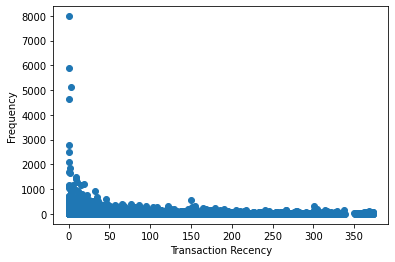

<AxesSubplot:xlabel='transactionRecency'>

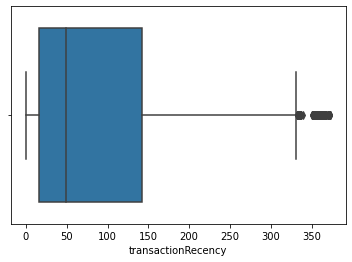

In [13]:
plt.scatter(grouped_df['transactionRecency'], grouped_df['Frequency'])
plt.xlabel('Transaction Recency')
plt.ylabel('Frequency')
plt.show()
sns.boxplot(x=grouped_df['transactionRecency'])


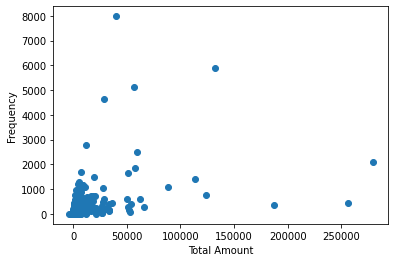

<AxesSubplot:xlabel='Frequency'>

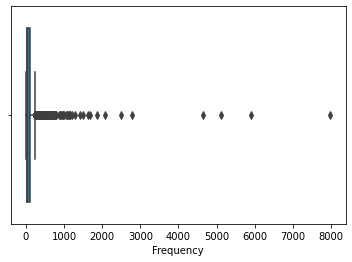

In [14]:
plt.scatter(grouped_df['amount'], grouped_df['Frequency'])
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.show()
sns.boxplot(x=grouped_df['Frequency'])

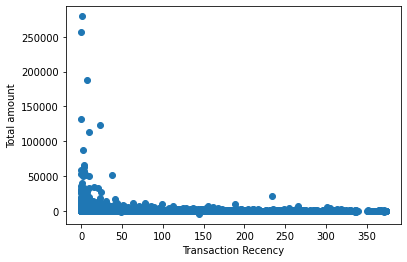

<AxesSubplot:xlabel='amount'>

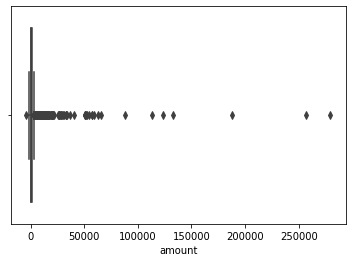

In [15]:
plt.scatter(grouped_df['transactionRecency'], grouped_df['amount'])
plt.xlabel('Transaction Recency')
plt.ylabel('Total amount')
plt.show()
sns.boxplot(x=grouped_df['amount'])

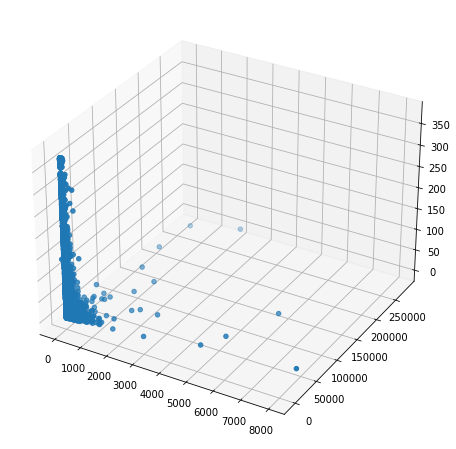

In [16]:
fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_df['Frequency'], grouped_df['amount'], grouped_df['transactionRecency'])

#### Z-Score
>*The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.*<br>

The intuition behind Z-score is to describe any data point by finding their relationship with the Standard Deviation and Mean of the group of data points. Z-score is finding the distribution of data where mean is 0.<br>
While calculating the Z-score we re-scale and center the data and look for data points which are too far from data set mean. These data points which are way too far from zero will be treated as the outliers. In most of the cases a threshold of 3 or -3 is used.<br> 

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT9HqVD2sf9MvI-IK5htHM5yMsGV12klim5uw&usqp=CAU)

In [17]:
zScore = np.abs(stats.zscore(grouped_df.loc[:, ['Frequency', 'amount', 'transactionRecency']])) 
threshhold = 3

outliers = np.where(zScore > 3)
outliers
# Output: 2 arrays, list of rows and column that satisfy condition Z-Score
# E.x: zScore[55][1] > 3


(array([  55,  330,  330,  458,  564,  564,  568,  568,  576,  698,  803,
        1005, 1078, 1273, 1295, 1300, 1300, 1345, 1345, 1348, 1447, 1447,
        1559, 1599, 1615, 1674, 1703, 1703, 1728, 1794, 1813, 1895, 1895,
        1953, 1980, 1999, 2192, 2192, 2375, 2498, 2537, 2590, 2708, 2722,
        2725, 2945, 3014, 3104, 3202, 3390, 3712, 3722, 3758, 3801, 3801,
        4023, 4042, 4042, 4053, 4125, 4233, 4245], dtype=int64),
 array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int64))

In [18]:
# Potential outliers
grouped_df.loc[outliers[0]]


,CustomerID,Frequency,amount,transactionRecency
55,12415.0,778,123725.45,23
330,12748.0,4642,29072.10,0
330,12748.0,4642,29072.10,0
458,12931.0,102,33462.81,21
564,13081.0,1061,27964.48,0
...,...,...,...,...
4042,17841.0,7983,40340.78,1
4053,17857.0,56,26763.34,2
4125,17949.0,79,52750.84,0
4233,18102.0,433,256438.49,0


#### IQR Score (Used)
> *The interquartile range (IQR), is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1. <br>
In other words, is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.
It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.*

IQR is somewhat similar to Z-score in terms of finding the distribution of data and then keeping some threshold to identify the outlier. <br>

***Notice that a customer that bought a great amount of money could be catalogued as an outlier, so i dont want to use lower 25% and upper 75% for outlier classification (i could find a customer inside the 75% - 100% catalogued as an outlier and he was just a good client)***
<br><br>

##### Why I used this one?
> Not all data is normal or normal enough to treat it as being drawn from a Gaussian distribution. A good statistic for summarizing a non-Gaussian distribution sample of data is the Interquartile Range, or IQR for short. <br>
In this case, the IQR approach is better.

<br><br>
[IQR explanation](https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/#:~:text=The%20IQR%20can%20be%20used,k%20is%20the%20value%201.5.)<br>
[Great video explanation](https://www.youtube.com/watch?v=A3gClkblXK8)

In [19]:
grouped_df

,CustomerID,Frequency,amount,transactionRecency
0,12346.0,2,0.00,325
1,12347.0,182,4310.00,1
2,12348.0,31,1797.24,74
3,12349.0,73,1757.55,18
4,12350.0,17,334.40,309
...,...,...,...,...
4367,18280.0,10,180.60,277
4368,18281.0,7,80.82,180
4369,18282.0,13,176.60,7
4370,18283.0,756,2094.88,3


In [20]:
#Amount
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1

lowerLimit = Q1 - 1.5*IQR
upperLimit = Q3 + 1.5*IQR
grouped_df = grouped_df[(grouped_df.amount >= lowerLimit) & (grouped_df.amount <= upperLimit)]

In [21]:
#Frequency
Q1 = grouped_df.Frequency.quantile(0.05)
Q3 = grouped_df.Frequency.quantile(0.95)
IQR = Q3 - Q1

lowerLimit = Q1 - 1.5*IQR
upperLimit = Q3 + 1.5*IQR
grouped_df = grouped_df[(grouped_df.Frequency >= lowerLimit) & (grouped_df.Frequency <= upperLimit)]

In [22]:
#Transaction Recency
Q1 = grouped_df.transactionRecency.quantile(0.05)
Q3 = grouped_df.transactionRecency.quantile(0.95)
IQR = Q3 - Q1

lowerLimit = Q1 - 1.5*IQR
upperLimit = Q3 + 1.5*IQR
grouped_df = grouped_df[(grouped_df.transactionRecency >= lowerLimit) & (grouped_df.transactionRecency <= upperLimit)]

#### Cleaned Data

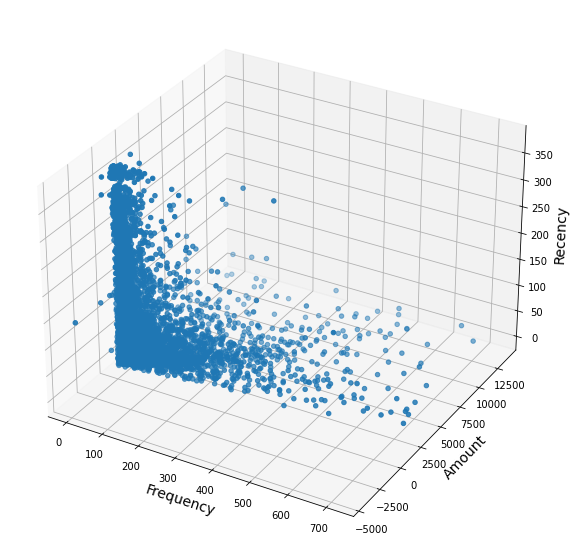

In [23]:
fig = plt.figure(figsize = [10,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grouped_df['Frequency'], grouped_df['amount'], grouped_df['transactionRecency'])
ax.set_xlabel('Frequency' , fontsize = 14)
ax.set_ylabel('Amount' , fontsize = 14)
ax.set_zlabel('Recency' , fontsize = 14)
plt.show()

# 4. Modelling

In [24]:
# Select RFM columns
RFM_df = grouped_df[['Frequency', 'amount', 'transactionRecency']]

#Scale data, not as dataframe
scaledData = StandardScaler().fit_transform(RFM_df)

# Transform scaled data intt a pandas dataframe
scaled_df = pd.DataFrame(scaledData)
scaled_df.columns = ['amount', 'Frequency', 'transactionRecency']
scaled_df.head(5)

,amount,Frequency,transactionRecency
0,-0.752888,-0.723738,2.301611
1,1.042467,1.731617,-0.906466
2,-0.463636,0.300128,-0.183658
3,-0.044720,0.277517,-0.738141
4,-0.603275,-0.533235,2.143188


#### Define initial *K*
We can plot the score value in function of K. For that we iterate applying K-Means every time, and saving the score value for every iteration.
When we find a small amount of the score function (within-cluster distance) is the k we should use.<br>
We should select K where the score function make a significant break into a lineal curve.<br><br>
> ***It can be seen below that when we have a number of clusters equal to 3, the score function makes an important break. Then, we should use 3 as the number of clusters when modelling***

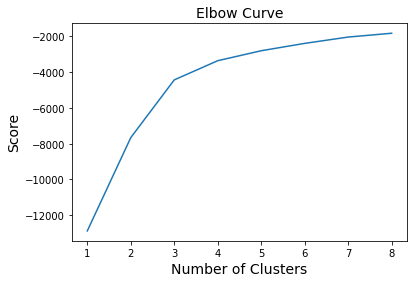

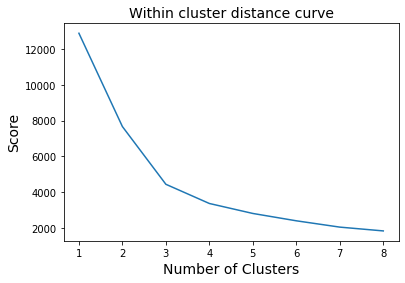

In [25]:
numClusters = [1,2,3,4,5,6,7,8]

# Way 1
kmeans = [KMeans(n_clusters = i) for i in numClusters]
score = [kmeans[i].fit(scaled_df).score(scaled_df) for i in range(len(kmeans))]
plt.plot(numClusters,score)
plt.xlabel('Number of Clusters', fontsize = 14)
plt.ylabel('Score', fontsize = 14)
plt.title('Elbow Curve', fontsize = 14)
plt.show()


# Way 2
score = [kmeans[i].fit(scaled_df).inertia_ for i in range(len(kmeans))]
plt.plot(numClusters,score)
plt.xlabel('Number of Clusters', fontsize = 14)
plt.ylabel('Score', fontsize = 14)
plt.title('Within cluster distance curve', fontsize = 14)
plt.show()
